## Часть 1. EDA


1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
2. Пройдите по основным шагам работы с данными: 
3. выкиньте ненужные признаки: id, name, host_id, host_name, last_review
4. визуализируйте базовые статистики данных: распределения признаков, матрицу попарных корреляций, постройте pair plots
5. по результатам анализа произведите предобработку переменных 

## Часть 2. Preprocessing & Feature Engineering

1. Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.
2. Опробуйте различные техники:

– работа с категориальными переменными (можно начать с dummy);

– замена аномалий;

– различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.);

– обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;

3. Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.


## Часть 3. Моделирование

1. Отложите 30% данных для тестирования.
2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
3. Измерьте качество каждой и визуализируйте важность признаков.
4. Сделайте интересные выводы :)

В ноутбуке желательно видеть:

Понятное описание: какие техники и алгоритмы были опробованы - было бы неплохо в самом начале тезисно выписать опробованные методики и их результат (помогло / не помогло).
Наличие визуализаций (не обязательно строить много графиков - можно несколько репрезентативных).
Наличие хотя бы одной модификации данных, приводящей к улучшению результатов.

In [2]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from statsmodels.tools import categorical

### Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data


In [3]:
# loading the data from pc
data = pd.read_csv('AB_NYC_2019.csv', index_col=0)
cols_2_drop = ['name', 'host_id', 'host_name', 'last_review',]
categorical_columns = ['neighbourhood_group','neighbourhood','room_type']
data = data.drop(cols_2_drop, axis=1)
data.head

<bound method NDFrame.head of          neighbourhood_group       neighbourhood  latitude  longitude  \
id                                                                      
2539                Brooklyn          Kensington  40.64749  -73.97237   
2595               Manhattan             Midtown  40.75362  -73.98377   
3647               Manhattan              Harlem  40.80902  -73.94190   
3831                Brooklyn        Clinton Hill  40.68514  -73.95976   
5022               Manhattan         East Harlem  40.79851  -73.94399   
...                      ...                 ...       ...        ...   
36484665            Brooklyn  Bedford-Stuyvesant  40.67853  -73.94995   
36485057            Brooklyn            Bushwick  40.70184  -73.93317   
36485431           Manhattan              Harlem  40.81475  -73.94867   
36485609           Manhattan      Hell's Kitchen  40.75751  -73.99112   
36487245           Manhattan      Hell's Kitchen  40.76404  -73.98933   

                room

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 2539 to 36487245
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.5+ MB


In [5]:
data.isnull().sum()
## поставим тут просто 0 reviews_per_month
   # Replace missing values (NaN) with -999 for 'Age' feature
data.loc[:, 'reviews_per_month'] = data.reviews_per_month.fillna(0)

In [6]:
data.describe(include='all')

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
unique,5,221,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN
freq,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,NaN,NaN,0.054530,0.046157,NaN,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000


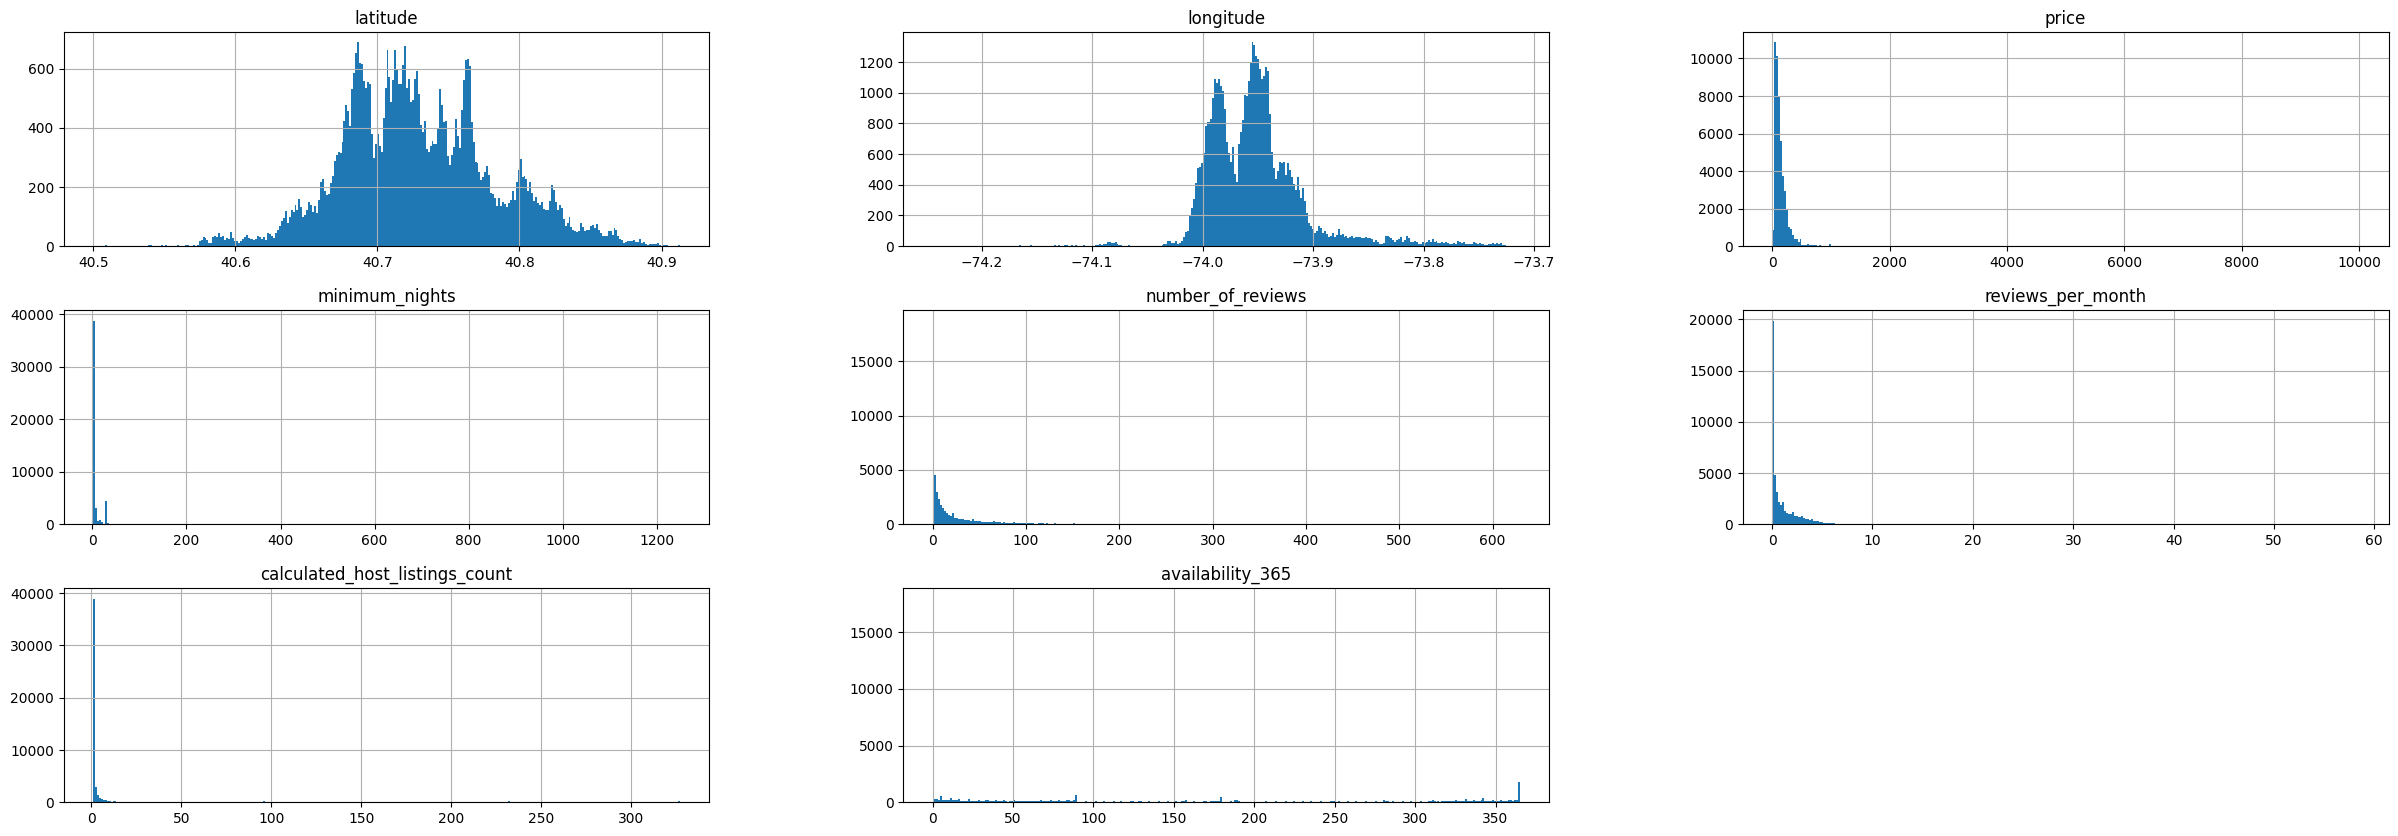

In [7]:
data.hist(bins=300,figsize = (30,10));

In [8]:
data[data['price']>9000]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,
4737930,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,0.02,1,0
7003697,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,0.04,1,0
9528920,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,0.14,1,83
13894339,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,0.16,1,0
22436899,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,0.00,1,83
31340283,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999,30,0,0.00,1,365


### Попытка понять, а что творится внутри различных районов города
но попытка не очень удачная

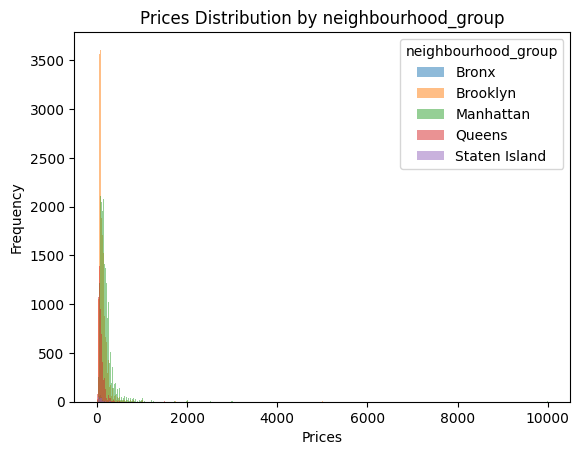

In [9]:
from matplotlib import pyplot as plt

#define points values by groupnin
Bronx = data.loc[data['neighbourhood_group'] == 'Bronx', 'price']
Brooklyn = data.loc[data['neighbourhood_group'] == 'Brooklyn', 'price']
Manhattan = data.loc[data['neighbourhood_group'] == 'Manhattan', 'price']
Queens = data.loc[data['neighbourhood_group'] == 'Queens', 'price']
Staten_Island = data.loc[data['neighbourhood_group'] == 'Staten Island', 'price']

#add three histograms to one plot
plt.hist(Bronx, bins=500, alpha=0.5, label='Bronx')
plt.hist(Brooklyn,bins=500, alpha=0.5, label='Brooklyn')
plt.hist(Manhattan,bins=500, alpha=0.5, label='Manhattan')
plt.hist(Queens,bins=500, alpha=0.5, label='Queens')
plt.hist(Staten_Island,bins=500, alpha=0.5, label='Staten Island')

#add plot title and axis labels
plt.title('Prices Distribution by neighbourhood_group')
plt.xlabel('Prices')
plt.ylabel('Frequency')

#add legend
plt.legend(title='neighbourhood_group')

#display plot
plt.show()

In [10]:
data.groupby('neighbourhood_group')['price'].describe()
# вот так получше, по медиане видно, что некоторые районы города дороже других 

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20104.0,124.383207,186.873538,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


In [11]:
data.groupby('neighbourhood')['price'].median()
# подрайоны города ещё сильнее влияют на распределение цен

neighbourhood
Allerton            66.5
Arden Heights       72.5
Arrochar            65.0
Arverne            125.0
Astoria             85.0
                   ...  
Windsor Terrace    123.0
Woodhaven           52.0
Woodlawn            68.0
Woodrow            700.0
Woodside            60.0
Name: price, Length: 221, dtype: float64

In [12]:
data.drop(categorical_columns, axis=1).corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.018758,0.019517,-0.010983
longitude,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.138516,-0.114713,0.082731
price,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.050564,0.057472,0.081829
minimum_nights,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.124905,0.127960,0.144303
number_of_reviews,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.589407,-0.072376,0.172028
reviews_per_month,-0.018758,0.138516,-0.050564,-0.124905,0.589407,1.000000,-0.047312,0.163732
calculated_host_listings_count,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.047312,1.000000,0.225701
availability_365,-0.010983,0.082731,0.081829,0.144303,0.172028,0.163732,0.225701,1.000000


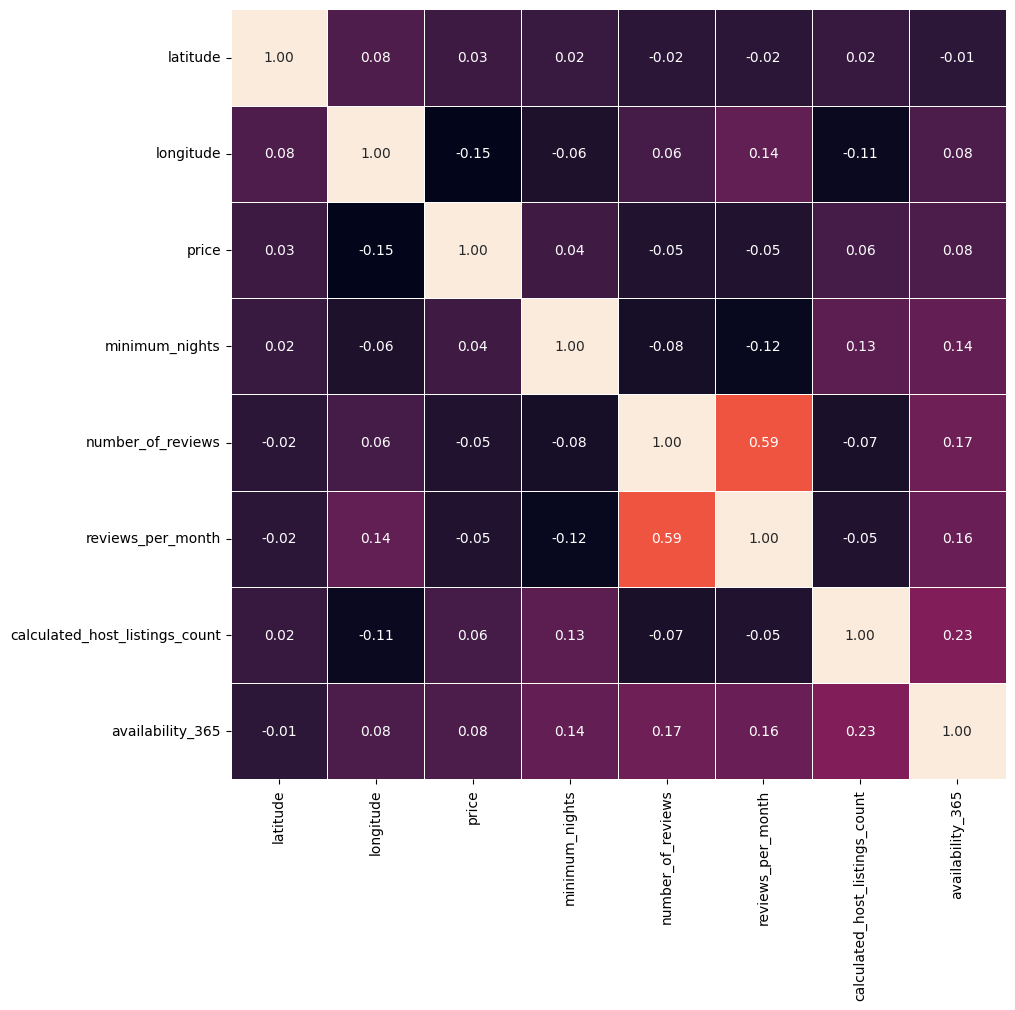

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.drop(categorical_columns, axis=1).corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()
# А никакой корреляции особо и нет

### Начнём готовить данные

In [14]:
### заменим категориальные переменные
data = pd.get_dummies(data, columns=categorical_columns, prefix_sep='=')
#data=data.drop(categorical_columns, axis=1)
### разделим на train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price'], test_size=0.3, random_state=84)
### сделаем масштабирование данных
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
type(X_train)

pandas.core.frame.DataFrame

### Пробуем стандартную линейную регрессию

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg.coef_, lin_reg.intercept_

(array([ 1.23944373e+01, -3.29399102e+01, -1.46804027e-01, -5.03829137e+00,
        -4.20766034e+00, -2.18320284e-01,  4.57055026e+01,  6.25688683e+11,
         5.90785111e+11,  5.40152773e+11,  5.66529630e+11,  5.64433721e+11,
        -4.84945580e+10,  1.27604038e+10,  1.27604039e+10,  1.06644950e+10,
         1.06644949e+10, -1.35909865e+10,  3.70413518e+10, -1.35909864e+10,
         1.06644950e+10,  1.27604040e+10, -4.84945580e+10,  1.06644951e+10,
         1.06644950e+10, -1.35909864e+10,  1.06644950e+10,  1.06644950e+10,
        -4.84945580e+10, -1.35909864e+10, -1.35909864e+10, -1.35909864e+10,
        -1.35909864e+10,  1.06644951e+10,  1.06644949e+10, -1.35909864e+10,
        -4.84945580e+10, -1.35909863e+10, -1.35909864e+10,  1.27604039e+10,
        -1.35909864e+10,  1.06644950e+10, -1.35909864e+10, -1.35909864e+10,
        -4.84945580e+10,  1.27604039e+10,  3.70413517e+10,  3.70413516e+10,
        -4.84945578e+10,  3.70413517e+10, -4.84945580e+10, -4.84945580e+10,
         1.2

In [16]:
y_pred = lin_reg.predict(X_test_scaled)
y_train_pred = lin_reg.predict(X_train_scaled)

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("-------------------------------------------------")
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))


Test MAE = 8228852.6734
Test RMSE = 575356532.0613
Test R2 = -4826408598005.2598
-------------------------------------------------
Train MAE = 71.2284
Train RMSE = 214.6502
Train R2 = 0.1306


#### Линейная регрессия - результат из коробки
**ОТВРАТИТЕЛЬНО**

Test MSE = 374753913928276963821092864.0000

Test MAE = 237826771727.5192

Test RMSE = 19358561773238.1406

Test R2 = -5463817278921853894656.0000

#### Пробуем RidgeCV

In [17]:
# Импорт класса Ridge из модуля linear_model scikit-learn
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()

ridge_model = ridge.fit(X_train_scaled, y_train)

y_pred = ridge_model.predict(X_test_scaled)
y_train_pred = ridge_model.predict(X_train_scaled)

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("-------------------------------------------------")
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
### уже лучше

Test MAE = 71.9829
Test RMSE = 249.4941
Test R2 = 0.0925
-------------------------------------------------
Train MAE = 71.0685
Train RMSE = 214.8307
Train R2 = 0.1291


#### Пробуем LassoCV

In [18]:
# Импорт класса Ridge из модуля linear_model scikit-learn
from sklearn.linear_model import LassoCV

lasso =  LassoCV(cv=10)

lasso_model = lasso.fit(X_train_scaled, y_train)

y_pred = lasso_model.predict(X_test_scaled)
y_train_pred = lasso_model.predict(X_train_scaled)

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("-------------------------------------------------")
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
### тут стало ещё лучше

Test MAE = 71.9974
Test RMSE = 249.8734
Test R2 = 0.0897
-------------------------------------------------
Train MAE = 71.7659
Train RMSE = 216.4926
Train R2 = 0.1156


#### Пробуем ElasticNetCV

In [19]:
from sklearn.linear_model import ElasticNetCV

# Передача в GridSearchCV Ridge-модели, потенциальных альфа-значений,
# метрики качества
elasticnet = ElasticNetCV(  cv=10)
elasticnet = elasticnet.fit(X_train_scaled, y_train)
y_pred = elasticnet.predict(X_test_scaled)
y_train_pred = elasticnet.predict(X_train_scaled)

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("-------------------------------------------------")
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test MAE = 76.6501
Test RMSE = 253.5084
Test R2 = 0.0630
-------------------------------------------------
Train MAE = 76.6155
Train RMSE = 220.8486
Train R2 = 0.0796


In [20]:
feature_importances = zip(X_train.columns, abs(lin_reg.coef_))
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'Lin Reg'])
feature_importances.insert(2,'RidgeCV', abs(ridge_model.coef_) )
feature_importances.insert(3,'LassoCV', abs(lasso_model.coef_) )
feature_importances.insert(4,'ElasticNetCV', abs(elasticnet.coef_) )
feature_importances.transpose()


,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
feature,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group=Bronx,neighbourhood_group=Brooklyn,neighbourhood_group=Manhattan,...,neighbourhood=Williamsburg,neighbourhood=Willowbrook,neighbourhood=Windsor Terrace,neighbourhood=Woodhaven,neighbourhood=Woodlawn,neighbourhood=Woodrow,neighbourhood=Woodside,room_type=Entire home/apt,room_type=Private room,room_type=Shared room
Lin Reg,12.394437,32.93991,0.146804,5.038291,4.20766,0.21832,45.705503,625688683018.684937,590785111440.057251,540152773429.542542,...,13590986360.586609,0.0,13590986402.085808,10664494893.048496,48494557972.666763,0.0,10664494880.258244,62031399448.346924,62031399545.324097,62031399576.765472
RidgeCV,0.18047,18.753154,0.139472,5.029036,4.431033,0.214179,45.507573,1.390603,5.686294,60.940169,...,28.874347,0.0,13.218381,30.246779,1.48794,0.0,24.325944,75.334891,22.143911,53.190979
LassoCV,0.681967,13.743345,0.009324,4.769606,4.47648,0.152503,42.348787,0.0,0.0,54.358061,...,20.682128,0.0,0.0,0.0,0.0,0.0,0.0,102.423858,0.0,14.46365
ElasticNetCV,1.246131,17.45077,0.917303,3.677463,3.026329,0.122731,14.643519,0.469933,8.870977,13.997776,...,0.422312,0.0,0.0,0.0,0.0,0.0,0.0,28.584567,24.708534,2.876018


### Анализ влияния коэффициентов
*на будущее: надо немного по другому было собрать эти данные*

- Большее влияние имеет тип комнаты. Очевидно, что целиком квартира будет стоить дороже чер отдельная комната или общая комната. 

- Далее влияние имеет подрайон "neighbourhood" из-за его кодирования, глазами обработать точные значения затруднительно.

- Имеет влияние количество обзоров, возможно квартиры без обзоров сдаются дешевле, в рамках демпинга

- Что широта не влияет, а долгота влияет. Чтобы это понять, можно было бы попробовать отобразить тепловую карту стоимости. 

#### RobustScaler vs StandartScaler

Особой разницы нет, хотя и написано, что RobustScaler лучше относится к выбросам. 

### Мысли, что ещё можно было бы сделать

1. попробовать, разделить стоимость на части, так как графику видно, что распределение очень смещено вправо. Я думаю если взять ограничить выборку от нуля до третьего квартиля по стоимости, то можно получить лучшие результаты по предсказанию, но не придумал, что делать в таком варианте с последней четвертью. Также возникла мысль про нормализацию результатов, но на лекциях такой темы не было.

2.  Попробовал сделать отображение на карте, но быстро не получилось. Может было бы просто красиво, а может и возникли полезные мысли.

     